### Logistic Regression

https://github.com/nborwankar/LearnDataScience/blob/master/notebooks/B3.%20Logistic%20Regression%20-%20Analysis.ipynb

What if data (y) is Yes or No?

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def nfl_outcomes(rline = False):
    scores = [3,11,12,13,20,22,21,25, 26,27,28,29,30,31,33,35,37,41,42,43]
    outcomes = [0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1]
    figsize = (8, 5)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    line = ax.plot(scores,outcomes,'o')[0]
    if rline:
        x = np.arange(5,50,5)
        y = (1.1/30.)*x-0.3
        line2 = ax.plot(x,y)
    ax.set_title('Win/Loss Outcomes for an NFL team')
    ax.set_xlabel('Score')
    ax.set_ylabel('Proability of a Win')
    ax.set_ylim((-0.1,1.1))
    ax.grid(True)
    #line.set_marker('o')
    plt.show()
    return ax,fig

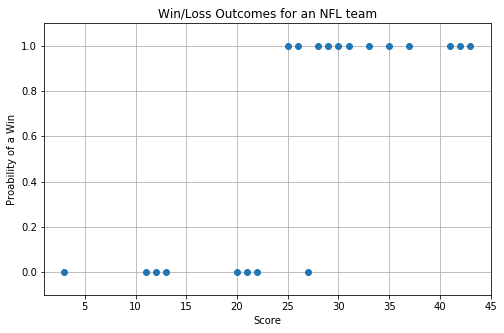

(<matplotlib.axes._subplots.AxesSubplot at 0x255d687e208>,
 <matplotlib.figure.Figure at 0x255d684ab70>)

In [2]:
nfl_outcomes()

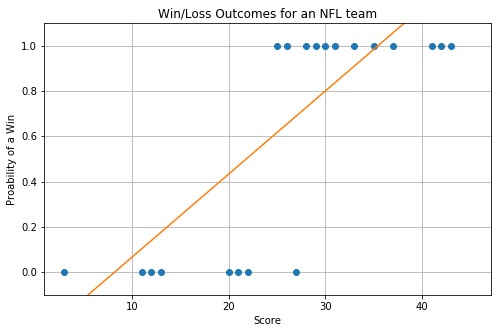

(<matplotlib.axes._subplots.AxesSubplot at 0x255d8a893c8>,
 <matplotlib.figure.Figure at 0x255d8a9f470>)

In [3]:
nfl_outcomes(True)

### How do we model this kind of data best?

Take a look at wiki's figures.
https://en.wikipedia.org/wiki/Logistic_regression


Now we cannot use a 'line' to fit (X,y) data, rather we use a logistic function and the concept of *probability*.

The question that we would like to ask is: what is the probability of Y=1 if we have X=x, i.e., P(Y=1|X=x).


The logistic function $ \sigma (t) $ is defined as follows:

$ \sigma (t)= {\frac {1}{1+e^{-t}}} $

Can we find a logistic function to fit the data (X, y) with a probability? Explain x=25 but y=0 with probability.

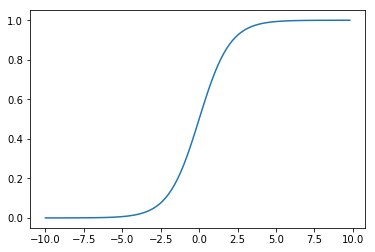

In [4]:
import math

def sigmoid(x):
    return 1/(1+math.exp(-x))

x = np.arange(-10., 10., 0.2)
y = list(map(sigmoid, x))

plt.plot(x, y)
plt.show()

### Now for a spot of Math

A function that has the above shape is:

$P(x)=\frac{1} {1+e^{b_0+b_{1}x}}$

where $P(x)$ is the probability of a $x$ leading to $y=1$.
$b_0, b_1$ are parameters that we will estimate, so the curve fits our data.

### Lending Club example

Problem: 
What is the probability of getting a Loan, from the Lending Club, of 10,000 dollars at 12 per cent or less with a FICO Score of 720?

$Interest Rate \rightarrow a_0 + a_1*FICOScore + a_2*LoanAmount$

$Prob (InterestRate < 12 \%)$

In [5]:
import pandas as pd
dfr = pd.read_csv('loanf.csv')

In [6]:
dfr.head()

,Interest.Rate,FICO.Score,Loan.Length,Monthly.Income,Loan.Amount
6,15.31,670,36,4891.67,6000
11,19.72,670,36,3575.00,2000
12,14.27,665,36,4250.00,10625
13,21.67,670,60,14166.67,28000
21,21.98,665,36,6666.67,22000


In [7]:
dfr['TF'] = dfr['Interest.Rate'] <= 12
dfr = dfr.drop(["Loan.Length", "Monthly.Income"], axis=1)
dfr.tail()

,Interest.Rate,FICO.Score,Loan.Amount,TF
2472,7.90,770,19000,True
2481,6.03,760,10000,True
2482,6.62,810,27000,True
2486,10.75,765,25000,True
2497,14.09,740,16000,False


In [8]:
import statsmodels.api as sm

dfr['intercept'] = 1.0
dfr.head()

,Interest.Rate,FICO.Score,Loan.Amount,TF,intercept
6,15.31,670,6000,False,1.0
11,19.72,670,2000,False,1.0
12,14.27,665,10625,False,1.0
13,21.67,670,28000,False,1.0
21,21.98,665,22000,False,1.0


In [9]:
ind_cols = ['FICO.Score', 'Loan.Amount', 'intercept']
logit = sm.Logit(dfr['TF'], dfr[ind_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.319503
         Iterations 8


In [10]:
coeff = result.params
print(coeff)

FICO.Score      0.087423
Loan.Amount    -0.000174
intercept     -60.125045
dtype: float64


Linear part of our predictor is

$z = -60.125 + 0.087423*FicoScore -0.000174*LoanAmount$


Finally, the probability of our desired outcome, i.e., our getting a loan at 12% interest or less, is

$p(z) = \frac{1}{1 + e^{b_0 + b_1*FicoScore + b_2*LoanAmount}}$

where  $b_0 = −60.125, b_1 = 0.087423$ and $b_2 = −0.000174$

We create a function in code that encapsulates all this.
It takes as input, a borrowers FICO score, the desired loan amount and the coefficient vector from our model. It returns a probability of getting the loan, a number between 0 and 1.

In [11]:
def pz(fico, amt, coeff):
    # compute the linear expression by multipyling the inputs by their respective coefficients.
    # note that the coefficient array has the intercept coefficient at the end
    z = coeff[0]*fico + coeff[1]*amt + coeff[2]
    return 1/(1+math.exp(-1*z))

In [12]:
# test
pz(720, 10000, coeff)

0.7463785889515134

### Plot

In [13]:
xx, yy = np.mgrid[600:850:10, 0:40000:100]

grid = np.c_[xx.ravel(), yy.ravel()]
probs = np.array(list(map(lambda z: pz(z[0],z[1],coeff), grid))).reshape(xx.shape)

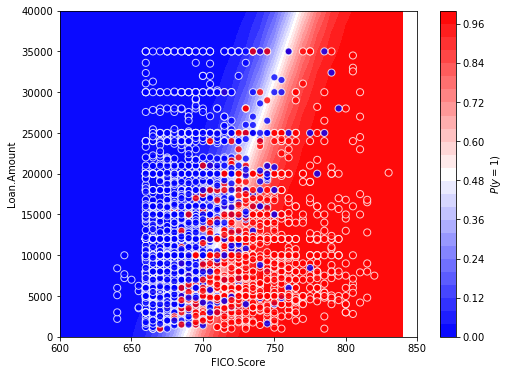

In [14]:
# fig
f, ax = plt.subplots(figsize=(8, 6))
# color
contour = ax.contourf(xx, yy, probs, 25, cmap="bwr", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")

ax.scatter( dfr['FICO.Score'],  dfr['Loan.Amount'], c = list(map(lambda a: 1.0 if a==True else 0.0, dfr['TF'])), s=50,
           cmap="bwr", alpha = 0.8,
           edgecolor="white", linewidth=1)

ax.set(#aspect="equal",
       xlim=(600, 850), ylim=(0, 40000),
       xlabel="FICO.Score", ylabel="Loan.Amount")

plt.show()

This value of 0.746 tells us we have a good chance of getting the loan we want.

### Use sklearn

In [15]:
from sklearn import linear_model

lr = linear_model.LogisticRegression(C=1e5) # C really matters!
X = np.array([3,11,12,13,20,22,21,25, 26,27,28,29,30,31,33,35,37,41,42,43])
X = X.reshape(-1, 1) # Try to comment this line.
y = [0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1]

lr.fit(X, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [16]:
print(X)

[[ 3]
 [11]
 [12]
 [13]
 [20]
 [22]
 [21]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [33]
 [35]
 [37]
 [41]
 [42]
 [43]]


In [17]:
print(lr.predict_proba([[5]]))
print(lr.coef_, lr.intercept_)

[[  9.99999614e-01   3.85524186e-07]]
[[ 0.73968338]] [-18.46707841]


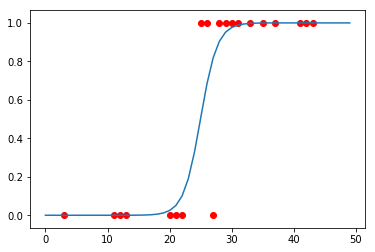

In [18]:
xx = np.linspace(0, 49).reshape(-1, 1)
probs = lr.predict_proba(xx)[:, 1].reshape(xx.shape)

plt.scatter(X.ravel(), y, c='red')
plt.plot(xx, probs)
plt.show()

In [19]:
# https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression